### Imports

In [1]:
# Libraries
import os
from importlib import reload
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [15]:
# Should be v2.10
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [16]:
# Should be v2.10
!pip show keras 

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [17]:
reload(runners)
reload(data)
reload(utils)
reload(generators)

<module 'helpers.generators' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\generators.py'>

In [18]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [19]:
NUM_FOLDS = 10
NUM_EPOCHS = 50
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 4

In [20]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv="../data/DATASET_CSVS/deepship_5k_seg_3s.csv",
    new_path_to_root="../data/deepship_baseline_unnorm_mat",
    ext="mat", 
    n_folds=NUM_FOLDS,
    unix=False
)

In [21]:
train_df, val_df, test_df = data.generate_kth_fold(fold_dfs, test_idx=1, val_idx=0)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

del fold_dfs

(43470, 5)
(4534, 5)
(5498, 5)


In [22]:
train_gen = generators.DeepShipGenerator(
    df=train_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

val_gen = generators.DeepShipGenerator(
    df=val_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

test_gen = generators.DeepShipGenerator(
    df=test_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

### Initialise model

In [10]:
from models import irfan_2020, unet_n2n

# model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr]
)

model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 192, 192, 64  0           ['conv2d[0][0]']                 
                                )                                                              

### Train model

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="models/saved/same_spec_denoiser_05122024/unet/{epoch:02d}.keras",
    monitor='val_psnr',
    mode='max',
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/same_spec_denoiser_05122024/unet/training.log",
    separator=",",
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/same_spec_denoiser_05122024/unet/tmp"
)

: 

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, csv_logger, backup_callback],
    verbose=2
)

Epoch 1/50
2716/2716 - 8000s - loss: 0.0015 - psnr: 33.3471 - val_loss: 1.2073e-04 - val_psnr: 39.3717 - 8000s/epoch - 3s/step
Epoch 2/50
2716/2716 - 8313s - loss: 7.4055e-05 - psnr: 41.6543 - val_loss: 4.7665e-05 - val_psnr: 43.4256 - 8313s/epoch - 3s/step
Epoch 3/50
2716/2716 - 6922s - loss: 3.6608e-05 - psnr: 44.6203 - val_loss: 6.1030e-05 - val_psnr: 42.2660 - 6922s/epoch - 3s/step
Epoch 4/50
2716/2716 - 5484s - loss: 2.3271e-05 - psnr: 46.5766 - val_loss: 1.9043e-05 - val_psnr: 47.4288 - 5484s/epoch - 2s/step
Epoch 5/50
2716/2716 - 6291s - loss: 1.6648e-05 - psnr: 48.0420 - val_loss: 1.6108e-05 - val_psnr: 48.1252 - 6291s/epoch - 2s/step
Epoch 6/50
2716/2716 - 6749s - loss: 1.2739e-05 - psnr: 49.2234 - val_loss: 1.1063e-05 - val_psnr: 49.8019 - 6749s/epoch - 2s/step
Epoch 7/50
2716/2716 - 6539s - loss: 1.0047e-05 - psnr: 50.2303 - val_loss: 1.5210e-05 - val_psnr: 48.3173 - 6539s/epoch - 2s/step
Epoch 8/50
2716/2716 - 6288s - loss: 8.3024e-06 - psnr: 51.0857 - val_loss: 7.3663e-06 

In [24]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

343/343 - 214s - loss: 2.7259e-06 - psnr: 55.9230 - 214s/epoch - 625ms/step


In [ ]:
model.save("models/saved/same_spec_denoiser_05122024/unet/unet_denoiser.keras")

### Evaluation, metrics, and visualising denoised output

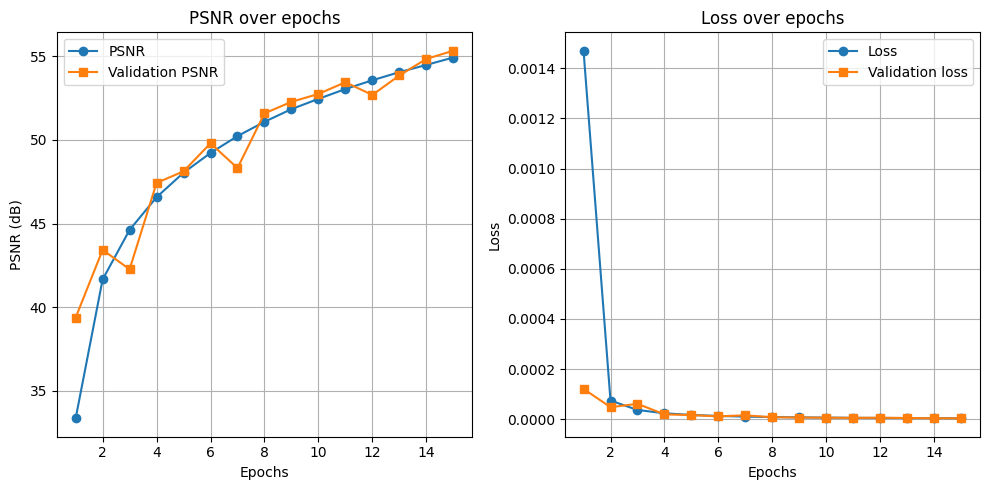

In [30]:
reload(utils)
fig = utils.get_psnr_and_loss_curves('models/saved/same_spec_denoiser_05122024/unet/training.log', together=True)
fig.savefig("models/saved/same_spec_denoiser_05122024/unet/img/psnr_loss_curves.pdf")

In [26]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_batch = next(iter(test_gen))[0]
sample_inputs = sample_batch[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 [==============================] - 5s 5s/step


In [27]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = utils.psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 3.3252842968067853e-06
PSNR on sample batch: [53.411026 56.868538 54.814594 56.17965  53.66506 ]


In [28]:
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.00504852132871747; Max: 1.0012304782867432
Sample 2 - Min: 9.71132903941907e-05; Max: 0.9998815059661865
Sample 3 - Min: -7.92309656389989e-05; Max: 0.9997915625572205
Sample 4 - Min: 0.00010038354230346158; Max: 1.0014580488204956
Sample 5 - Min: -0.000497653556521982; Max: 1.001816987991333


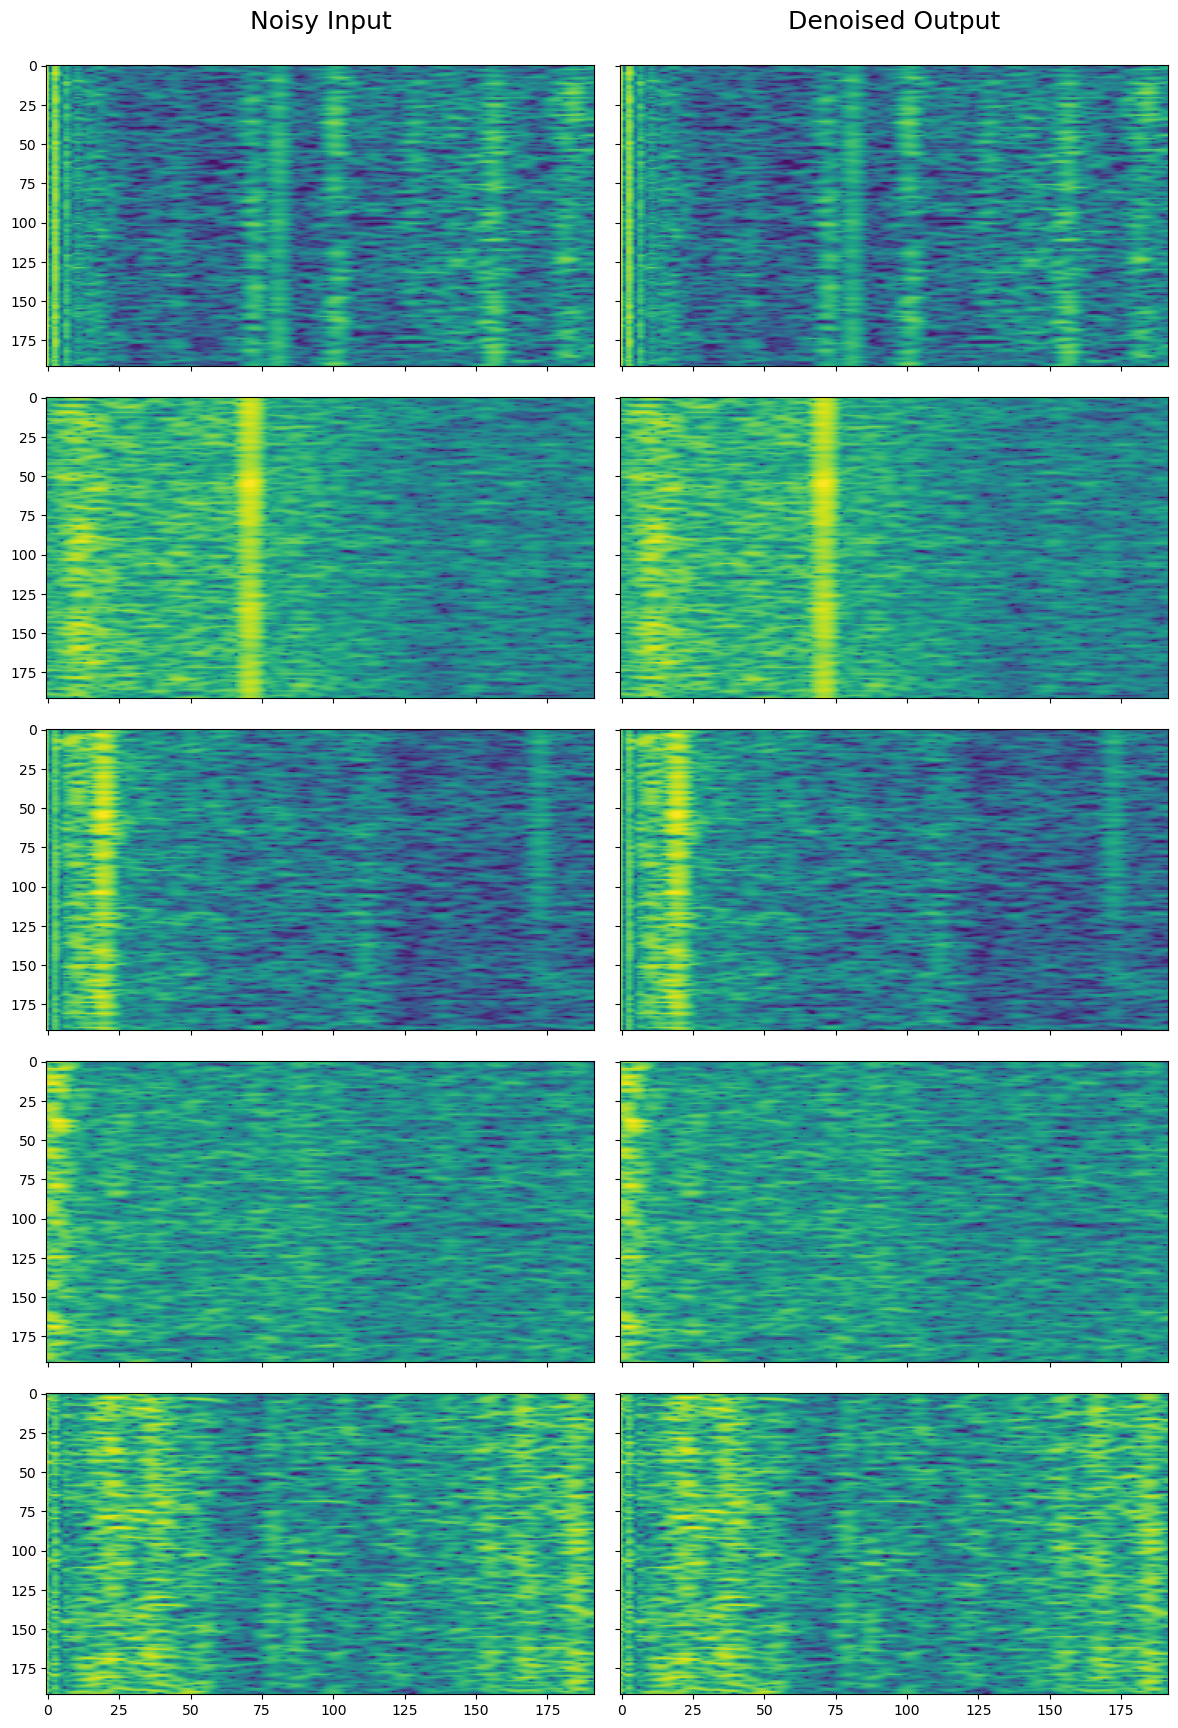

In [29]:
# Create a single figure
fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3.5), sharex=True, sharey=True)

# fig.tight_layout(pad=3.0)

for i in range(num_samples):
    axes[i, 0].imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 1].imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")

axes[0, 0].set_title(f"Noisy Input\n", fontsize=18)
axes[0, 1].set_title(f"Denoised Output\n", fontsize=18)

fig.tight_layout(pad=1.5)
fig.savefig(f"models/saved/same_spec_denoiser_05122024/unet/img/combined_spectrograms.pdf", bbox_inches="tight")

plt.show()

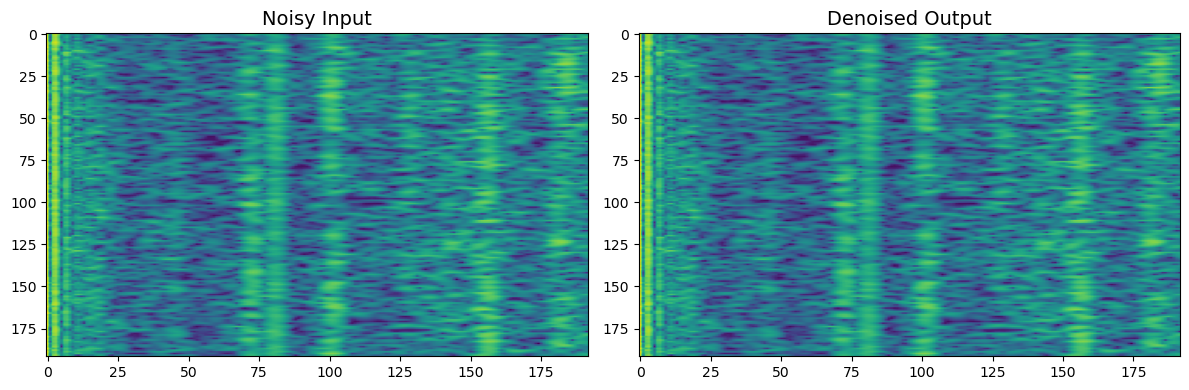

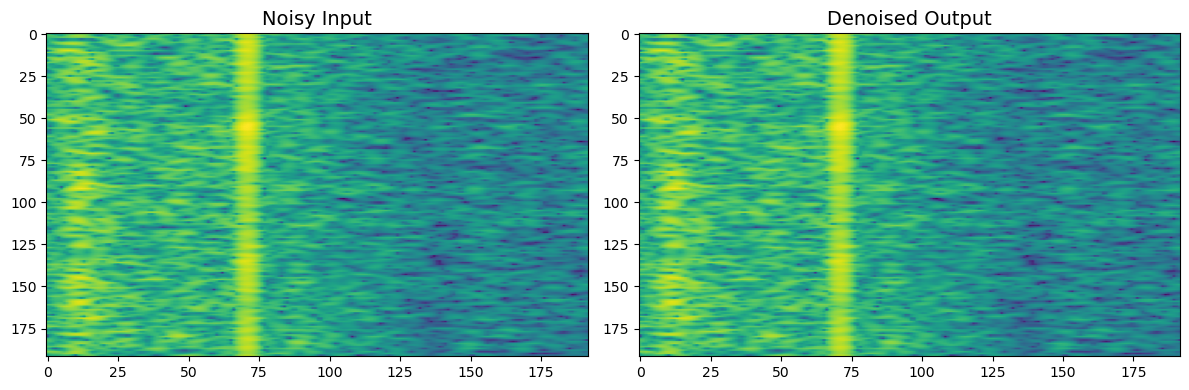

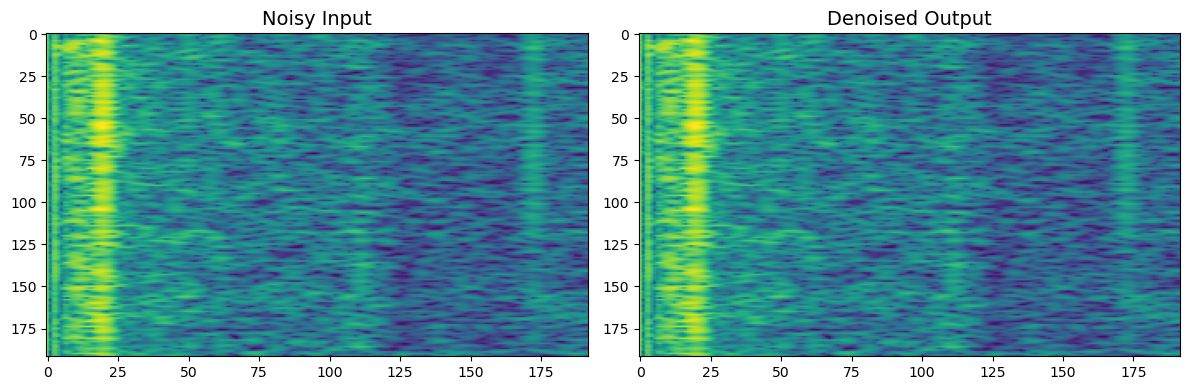

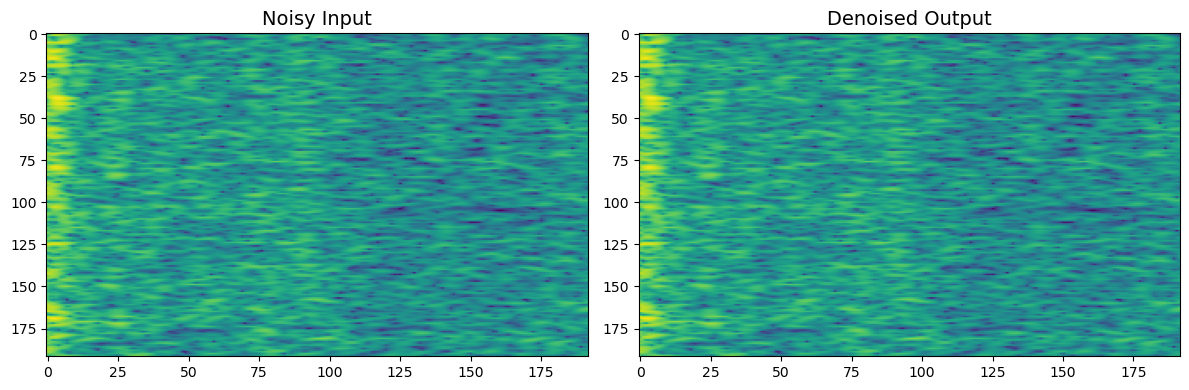

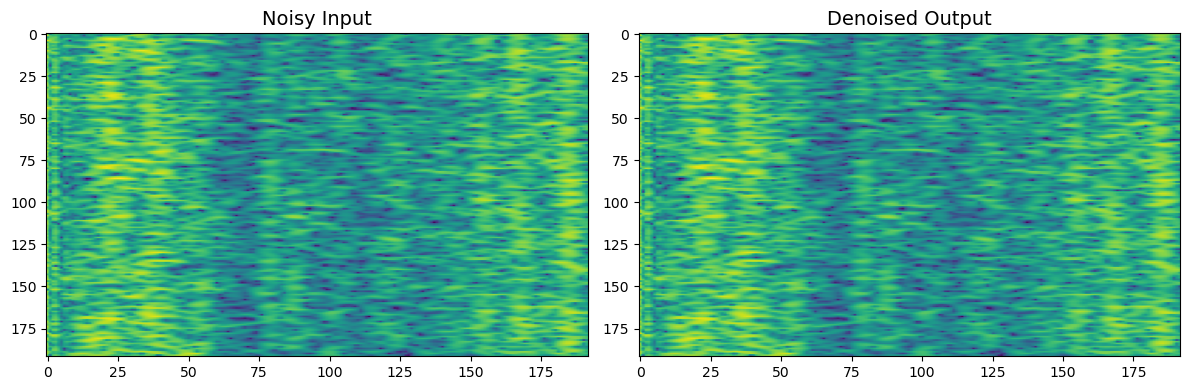

In [30]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))
    
    # Noisy Input
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input", fontdict={'size': 14})
    # plt.colorbar()

    # Denoised Output
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output", fontdict={'size': 14})
    # plt.colorbar()

    plt.tight_layout()
    plt.show()

    fig.savefig(f"models/saved/same_spec_denoiser_05122024/unet/img/ex{i + 1}.pdf")